In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
os.chdir('data')

In [3]:
import importlib
import helpers
importlib.reload(helpers)
from helpers import get_lagged_main_df, get_forecast, get_period
from helpers import r2_score_adj, mean_absolute_percentage_error
from helpers import Naive

In [4]:
import matplotlib.pyplot as plt 

In [5]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, ElasticNetCV
from sklearn.svm import SVR

In [6]:
from datetime import datetime, timedelta, date, time

# Load data

In [7]:
final_m_full_df = pd.read_csv('final_m_full_df.tsv', sep='\t')
final_m_full_df.set_index('period', inplace=True)
final_m_full_df.index = final_m_full_df.index.astype('datetime64[ns]', copy=False)

main_m_full_df = get_lagged_main_df(final_m_full_df, n_lag_target=12, n_lag_feature=12)
main_m_full_df = main_m_full_df.dropna()

In [115]:
final_m_df = pd.read_csv('final_m_df.tsv', sep='\t')
final_m_df.set_index('period', inplace=True)
final_m_df.index = final_m_df.index.astype('datetime64[ns]', copy=False)

main_m_df = get_lagged_main_df(final_m_df, n_lag_target=12, n_lag_feature=12)
main_m_df = main_m_df.dropna()

# Select features

In [87]:
main_m_df = main_m_full_df

In [137]:
from mlxtend.feature_selection import SequentialFeatureSelector
start_date = '2004-01-01'
finish_date = '2021-12-01'
split_start = 192 #2020-01-01
look_forward = 12
df = main_m_df[((main_m_df.index >= start_date) & ((main_m_df.index <= finish_date)))]
X = df.drop(['target'], axis=1)
y = df.target

splits = [(np.array(range(0, i)), 
           np.array(range(i, i + look_forward))) for i in range(split_start, 
                                                                X.shape[0] - (look_forward - 1), 1)]

scaler = StandardScaler()
scaler.fit(X)

sfs = SequentialFeatureSelector(
                                estimator=ElasticNet(),
                                #estimator=LinearRegression(),
                                forward=True,
                                k_features=(5, 35), 
                                cv=splits,
                                #scoring=r2_score_adj
                                scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False)
                               )
if scaler:
    sfs.fit(scaler.transform(X), y)
else:
    sfs.fit(X, y)
selected_cols_sfs = list(X.columns[list(sfs.k_feature_idx_)])
len(selected_cols_sfs)

35

In [138]:
selected_cols_sfs

['target_lag_1',
 'Handysize Bulker Scrap Value_8693_lag_4',
 'Handysize Bulker Scrap Value_8693_lag_5',
 'Handysize Bulker Scrap Value_8693_lag_6',
 'Handysize Bulker Scrap Value_8693_lag_std',
 'Inflation Indicator OECD Europe (excl Turkey)_lag_1',
 'Inflation Indicator OECD Europe (excl Turkey)_lag_4',
 'Inflation Indicator OECD Europe (excl Turkey)_lag_std',
 'Inflation Indicator USA_lag_1',
 'Inflation Indicator USA_lag_2',
 'Inflation Indicator USA_lag_std',
 'Inflation Indicator Japan_lag_1',
 'Inflation Indicator Japan_lag_2',
 'Inflation Indicator Japan_lag_3',
 'Inflation Indicator Japan_lag_4',
 'Inflation Indicator Japan_lag_12',
 'Inflation Indicator OECD_lag_1',
 'Inflation Indicator OECD_lag_2',
 'Inflation Indicator OECD_lag_std',
 'Brent Crude Oil Price_lag_10',
 'Brent Crude Oil Price_lag_11',
 'Brent Crude Oil Price_lag_12',
 'Japan Steel Ship Plate Commodity Price_lag_1',
 'Japan Steel Ship Plate Commodity Price_lag_2',
 'Japan Steel Ship Plate Commodity Price_lag_3

In [92]:
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(0,)","[0.5982603802396045, 0.6568603711302405, -1.96...",-0.129688,"(0,)",1.384239,1.076985,0.538492
2,"(0, 320)","[0.7078464825487347, 0.6142579563184888, 0.358...",0.560267,"(0, 320)",0.203181,0.158082,0.079041
3,"(0, 1, 320)","[0.695189899574583, 0.7385602379641204, 0.4207...",0.661871,"(0, 1, 320)",0.168377,0.131003,0.065501
4,"(0, 1, 320, 420)","[0.7438713406947313, 0.6820868691852842, 0.615...",0.720467,"(0, 1, 320, 420)",0.089727,0.069811,0.034905
5,"(0, 1, 320, 420, 515)","[0.7484649549878079, 0.6609465023561982, 0.795...",0.748448,"(0, 1, 320, 420, 515)",0.065159,0.050696,0.025348
6,"(0, 1, 320, 392, 420, 515)","[0.7553413490135152, 0.6990816429328848, 0.781...",0.77604,"(0, 1, 320, 392, 420, 515)",0.059545,0.046328,0.023164
7,"(0, 1, 320, 392, 420, 515, 711)","[0.749174244581278, 0.6888338679626655, 0.8008...",0.779736,"(0, 1, 320, 392, 420, 515, 711)",0.07099,0.055233,0.027616
8,"(0, 1, 320, 392, 420, 515, 711, 810)","[0.7364291503668554, 0.6858561278090074, 0.764...",0.785445,"(0, 1, 320, 392, 420, 515, 711, 810)",0.094931,0.07386,0.03693
9,"(0, 1, 221, 320, 392, 420, 515, 711, 810)","[0.7326054951635939, 0.6748830422393035, 0.826...",0.794637,"(0, 1, 221, 320, 392, 420, 515, 711, 810)",0.101394,0.078888,0.039444
10,"(0, 1, 221, 303, 320, 392, 420, 515, 711, 810)","[0.728554893020585, 0.6618931848153639, 0.8493...",0.796084,"(0, 1, 221, 303, 320, 392, 420, 515, 711, 810)",0.111604,0.086832,0.043416


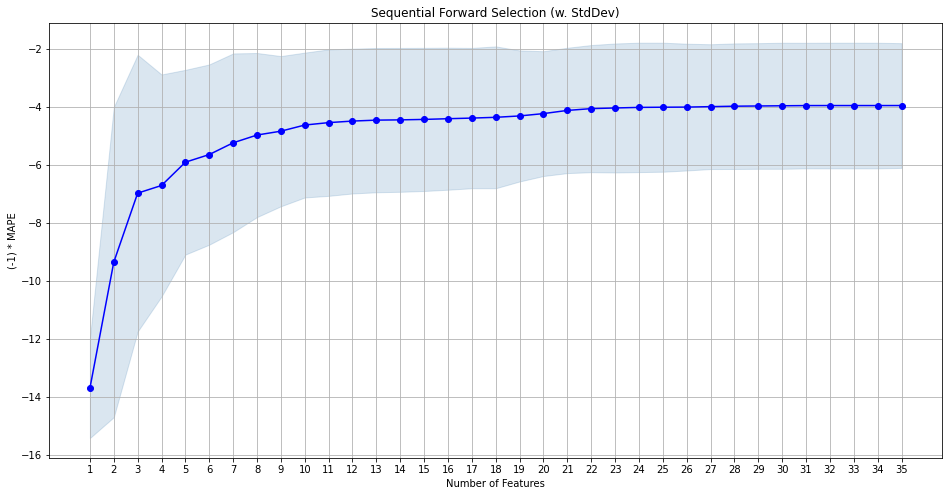

In [139]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), ylabel='(-1) * MAPE', figsize=(16,8))
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [140]:
filtered_df = main_m_df[['target'] + selected_cols_sfs]
train_df = filtered_df.copy()
train_df = train_df[((train_df.index >= start_date) & ((train_df.index <= finish_date)))]

X = train_df.drop(['target'], axis=1)
y = train_df.target

scaler = StandardScaler()
scaler.fit(X)
#scaler = None

StandardScaler()

In [141]:
if not scaler:
    scores = cross_val_score(ElasticNet(), X, y, cv=splits, scoring=make_scorer(mean_absolute_percentage_error))
else:
    scores = cross_val_score(ElasticNet(), scaler.transform(X), 
                             y, cv=splits, scoring=make_scorer(mean_absolute_percentage_error))
scores, np.mean(scores)

(array([1.36699094, 1.45777224, 1.08202266, 2.41454579, 3.14137074,
        3.59573867, 3.58601305, 3.91034135, 4.56409792, 4.99527681,
        5.48358129, 7.82484487, 8.05859304]),
 3.960091489915633)

In [88]:
if not scaler:
    scores = cross_val_score(ElasticNet(), X, y, cv=splits, scoring=make_scorer(mean_absolute_percentage_error))
else:
    scores = cross_val_score(ElasticNet(), scaler.transform(X), 
                             y, cv=splits, scoring=make_scorer(mean_absolute_percentage_error))
scores, np.mean(scores)

(array([12.22154983,  9.43409257, 13.8488693 ,  9.34688951,  9.83520568,
         8.24819928,  2.35260585]),
 9.32677314588668)

In [36]:
scores = cross_val_score(Naive(), X, y, cv=splits, scoring=make_scorer(mean_absolute_percentage_error))
scores, np.mean(scores)

(array([ 3.84440039,  4.29238718,  5.10466946,  7.19933332,  7.36198368,
         8.08548769,  8.37955641,  8.79407474,  9.4819748 ,  9.73739389,
         9.95904036, 12.4789397 , 12.71227841, 12.97811123, 12.91279195,
        11.74082471, 11.79777529, 10.63550281]),
 9.305362556748477)

In [121]:
X_train = X.iloc[splits[-1][0]]
y_train = y.iloc[splits[-1][0]]

X_val = X.iloc[splits[-1][1]]
y_val = y.iloc[splits[-1][1]]

In [122]:
model = ElasticNet()
if not scaler:
    model.fit(X_train, y_train)
    forecast = model.predict(X_val)
else:
    model.fit(scaler.transform(X_train), y_train)
    forecast = model.predict(scaler.transform(X_val))

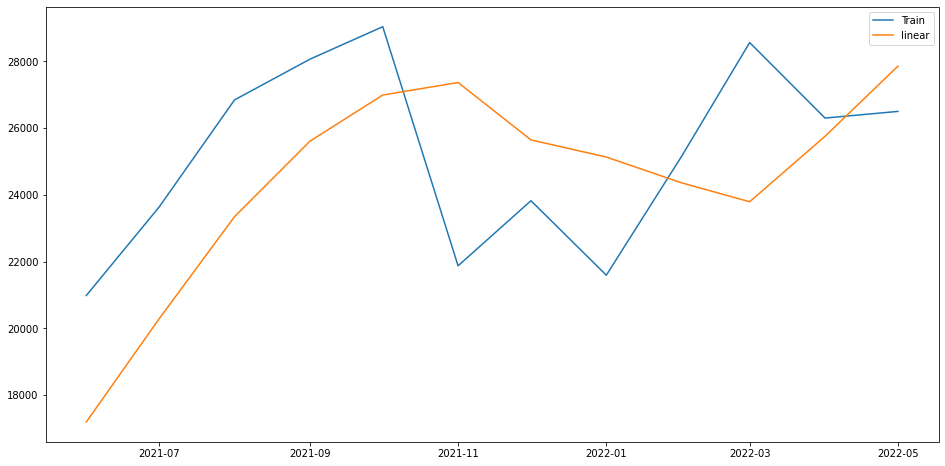

In [123]:
t = pd.DataFrame(y_val)
t['prediction'] = forecast
plt.figure(figsize=(16,8))
plt.plot(t.target, label='Train')
plt.plot(t.prediction, label='linear')
plt.legend(loc='best')
plt.show()

In [99]:
len(selected_cols_sfs)

10

In [52]:
date_points

[datetime.date(2021, 3, 1),
 datetime.date(2021, 4, 1),
 datetime.date(2021, 5, 1)]

In [54]:
from dateutil.relativedelta import relativedelta

In [56]:
date(2021, 12, 1) + relativedelta(months=2)

datetime.date(2022, 2, 1)

In [142]:
n_lag_target = 12
n_step = look_forward

forecasts = []
date_points = []
date_point_start = date(2021, 12, 1)
for i in range(0, 7):
    s_date = date_point_start + relativedelta(months=i + 1)
    f_date = date_point_start + relativedelta(months=i + n_step)
    forecast_df = pd.DataFrame(data={'period': 
                               get_period(start_date=s_date, 
                                          finish_date=f_date, period='m')})
    forecasts.append(forecast_df)
    date_points.append(date_point_start + relativedelta(months=i))
    
for i, date_point in enumerate(date_points):
    train_period_df = main_m_df[((main_m_df.index >= start_data) & ((main_m_df.index <= str(date_point))))]
    X_train = train_period_df.drop(['target'], axis=1)[selected_cols_sfs]
    y_train = train_period_df.target
    model = ElasticNet()
    if not scaler:
        model.fit(X_train, y_train)
    else:
        model.fit(scaler.transform(X_train), y_train)

    forecast_df = forecasts[i]
    forecast_df.set_index('period', inplace=True)
    forecast_df['pred'] = get_forecast(main_m_df.loc[str(date_point):str(date_point)], 
                                       model, selected_cols_sfs, 
                                       n_step=n_step, n_lag=n_lag_target, scaler=scaler)[0]
    

In [143]:
forecasts[0][:6]

,pred
period,
2022-01-01,24418.599633
2022-02-01,25686.507618
2022-03-01,26318.521650
2022-04-01,26633.561654
2022-05-01,26790.599629
2022-06-01,26868.878341


In [144]:
mean_absolute_percentage_error(main_m_df.target[-6:].values, forecasts[0][:6].pred.values)

5.391955911490933

In [145]:
forecast_m = pd.DataFrame(data={'period': 
                                get_period(start_date=date(2022, 1, 1),
                                           finish_date=date(2022, 7, 1)),
                                'pred': 
                                [forecasts[i].iloc[0].pred for i, _ in enumerate(forecasts)]})
forecast_m.set_index('period', inplace=True)

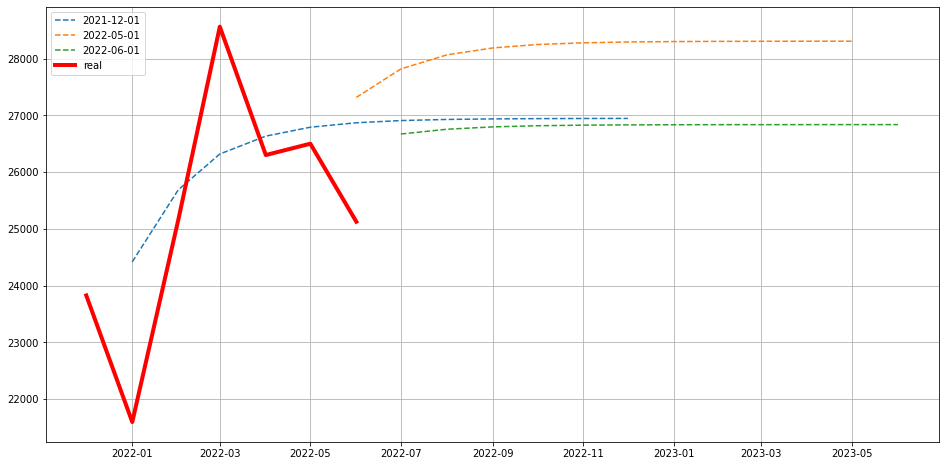

In [158]:
plt.figure(figsize=(16,8))
#for i, date_point_str in enumerate(date_points):
#    plt.plot(forecasts[i], label=date_point_str, linestyle='--')
plt.plot(forecasts[0], label=date_points[0], linestyle='--')
plt.plot(forecasts[5], label=date_points[5], linestyle='--')
plt.plot(forecasts[6], label=date_points[6], linestyle='--')
#plt.plot(forecast_m, label='forecast',
#         color='black', linestyle='-',
#         linewidth=4)
plt.plot(main_m_df[(main_m_df.index >= '2021-12-01')].target, label='real',
         color='red',
         linewidth=4)
plt.legend(loc='best')
plt.grid()
plt.show()

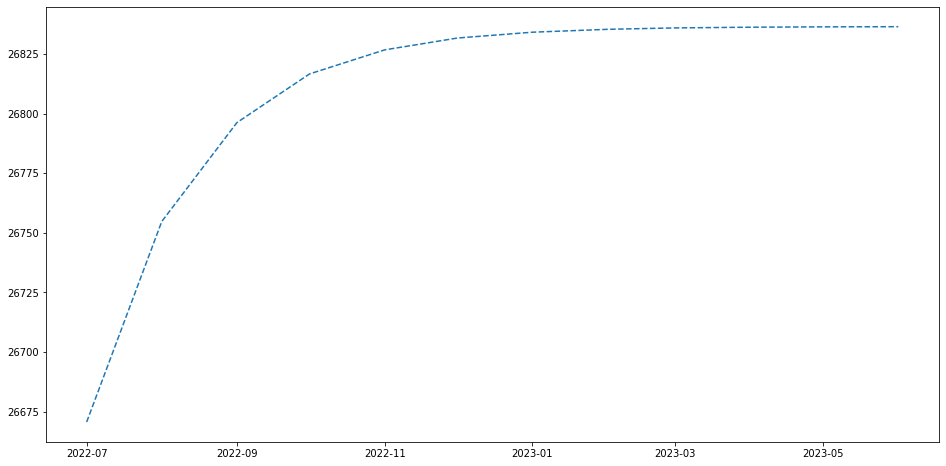

In [147]:
plt.figure(figsize=(16,8))
plt.plot(forecasts[6], label=date_points[6], linestyle='--')

In [148]:
forecasts[6]

,pred
period,
2022-07-01,26670.598222
2022-08-01,26754.702625
2022-09-01,26796.165839
2022-10-01,26816.607077
2022-11-01,26826.684546
2022-12-01,26831.652707
2023-01-01,26834.101995
2023-02-01,26835.309486
2023-03-01,26835.904776


In [149]:
finish_date = date(2022, 6, 24)
filtered_df = main_m_df[['target'] + selected_cols_sfs]
train_df = filtered_df.copy()
train_df = train_df[((train_df.index >= start_data) & ((train_df.index <= str(finish_date))))]

X = train_df.drop(['target'], axis=1)
y = train_df.target

In [150]:
mean_absolute_percentage_error(y, X.target_lag_1), r2_score(y, X.target_lag_1)

(6.71773855298246, 0.9447011910140313)

In [151]:
model = ElasticNet()
if not scaler:
    model.fit(X, y)
else:
    model.fit(scaler.transform(X), y)

In [152]:
if not scaler:
    forecast = model.predict(X)
else:
    forecast = model.predict(scaler.transform(X))
train_df['prediction'] = forecast
mean_absolute_percentage_error(y, forecast), r2_score(y, forecast)

(14.637646737864474, 0.8541030245569725)

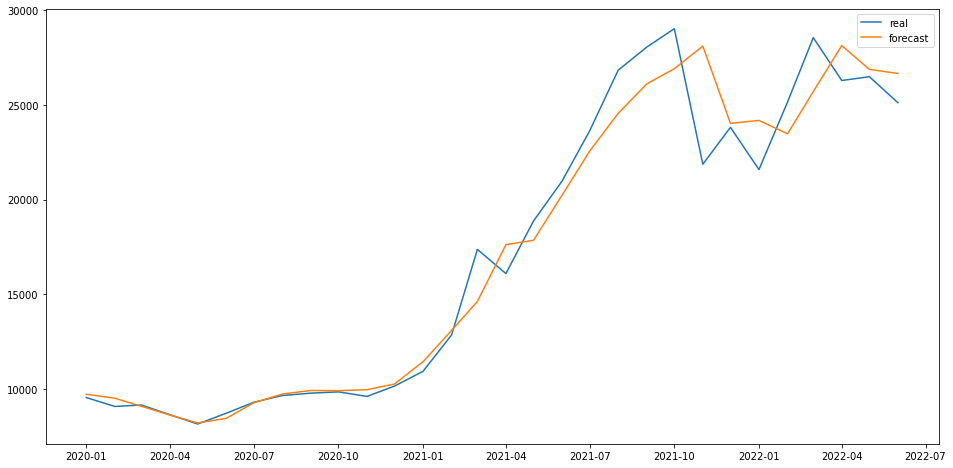

In [153]:
plt.figure(figsize=(16,8))
plt.plot(train_df[((train_df.index >= '2020-01-01') & ((train_df.index <= '2022-06-24')))].target, label='real')
plt.plot(train_df[((train_df.index >= '2020-01-01') & ((train_df.index <= '2022-06-24')))].prediction, label='forecast')
plt.legend(loc='best')
plt.show()

<AxesSubplot:>

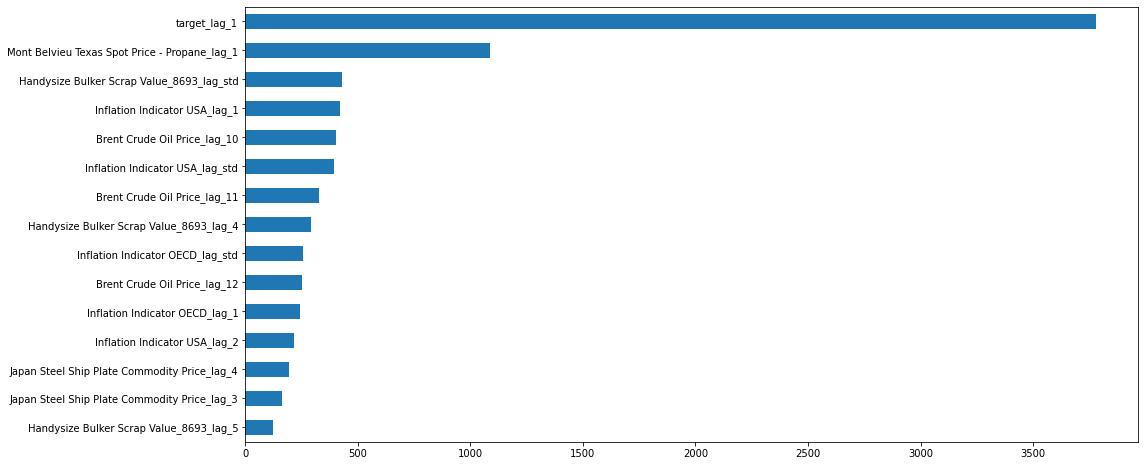

In [154]:
imp_df = pd.Series(abs(model.coef_), index=X.columns).sort_values()

plt.figure(figsize=(16,8))
imp_df[-15:].plot(kind='barh')

In [67]:
# get importance
feature_importances = abs(model.coef_)
# summarize feature importance
feature_names = X.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True)[:300]:
    print('{}: {}'.format(name, score))

target_lag_1: 3491.214230431761
Handysize Bulker Sales_33262_lag_1: 1449.3847217589887
Handysize Bulker Scrap Value_8693_lag_1: 1089.338229628199
Brent Crude Oil Price_lag_11: 654.946065788824
Saudi Posted Contract Price - Propane_lag_10: 543.1232417980805
Mont Belvieu Texas Spot Price - Propane_lag_7: 394.95055294316455
Mont Belvieu Texas Spot Price - Propane_lag_std: 324.75344070590785
Handysize Bulker Scrap Value_8693_lag_4: 256.4594055773361
Inflation Indicator Japan_lag_4: 221.64934730592623
Inflation Indicator OECD Europe (excl Turkey)_lag_1: 178.82564890404072
Inflation Indicator OECD Europe (excl Turkey)_lag_2: 153.19560646942085
Saudi Posted Contract Price - Propane_lag_2: 121.55309578464532
Inflation Indicator Japan_lag_9: 116.01751063247028
Natural Gas Spot Price, NGB Point Europe_lag_3: 90.64644850387049
Inflation Indicator Japan_lag_10: 77.44190280419205
Handysize Bulker Scrap Value_8693_lag_10: 70.98329155259273
Inflation Indicator OECD Europe (excl Turkey)_lag_mean: 66.8